# Librerias 📚

In [2]:
import glob
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import time

# IPNYB
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Autoencoder
# Data processing
from collections import Counter
# Model and performance
import tensorflow as tf
from tensorflow.keras import layers, losses
from sklearn.metrics import classification_report

from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential

from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

2023-06-24 09:49:42.828312: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-24 09:49:43.116305: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-24 09:49:43.120125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-24 09:49:44.693156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Obtain files 🗂️

In [2]:
files_MUM_03 = glob.glob('translations/0.3/mu-/*.json')
files_MUP_03 = glob.glob('translations/0.3/mu+/*.json')
files_MUM_01 = glob.glob('translations/0.1/mu-/*.json')
files_MUP_01 = glob.glob('translations/0.1/mu+/*.json')
files_NEU_03 = glob.glob('translations/0.3/neutron/*.json')

# Exploratory Data Analysis

In [ ]:
# Transform glob to pandas dataframe
# every row is a json file

def extract_translation(filelist):
        results = []
        
        # Iterate over files
        for file in filelist:
                # Open file
                with open(file) as f:
                        data = json.load(f)
                        
                for event, event_data in data.items():
                        side_1 = event_data['gruid hits - side 1']
                        side_2 = event_data['gruid hits - side 2']
                        metadata = event_data['gruid metadata']
                        run, event_n = event.split("event")
                        
                        for time, time_data in side_1.items():
                                for pixel, pixel_data in time_data.items():
                                        results.append({
                                                'run': run,
                                                #'event': int(event_n),
                                                #'channel': channel,
                                                'x': pixel[0],
                                                'y': pixel[2],
                                                'side': 1,
                                                'num_hits': pixel_data['# of hits'],
                                                'energy_deposited': pixel_data['energy deposited'],
                                                'particle_id': metadata['pid']
                                        })
                                        
                        for time, time_data in side_2.items():
                                for pixel, pixel_data in time_data.items():
                                        results.append({
                                                'run': run,
                                                #'event': int(event_n),
                                                #'channel': channel,
                                                'x': pixel[0],
                                                'y': pixel[2],
                                                'side': 2,
                                                'num_hits': pixel_data['# of hits'],
                                                'energy_deposited': pixel_data['energy deposited'],
                                                'particle_id': metadata['pid']
                                        })             
        return pd.DataFrame(results)

# 0.3 --------------------------------------------
# Extract dataframes
df_MUM_03 = extract_translation(files_MUM_03)
df_MUP_03 = extract_translation(files_MUP_03)

# Add label column
df_MUM_03['label'] = 1
df_MUP_03['label'] = 0

# Index dataframe
df_MUM_03 = df_MUM_03.set_index('run')
df_MUP_03 = df_MUP_03.set_index('run')

# 0.1 --------------------------------------------
# Extract dataframes
df_MUM_01 = extract_translation(files_MUM_01)
df_MUP_01 = extract_translation(files_MUP_01)

# Add label column
df_MUM_01['label'] = 1
df_MUP_01['label'] = 0

# Index dataframe
df_MUM_01 = df_MUM_01.set_index('run')
df_MUP_01 = df_MUP_01.set_index('run')

# Group by run
#df_MUM = df_MUM.groupby(df_MUM.index)
#df_MUP = df_MUP.groupby(df_MUP.index)

In [4]:
# Exploratory data analysis comparing the two datasets
df_MUM_03.describe()

,side,num_hits,energy_deposited,particle_id,label
count,68863.000000,68863.000000,6.886300e+04,68863.0,68863.0
mean,1.497669,9.140482,5.016518e-05,13.0,1.0
std,0.499998,15.925862,8.609125e-05,0.0,0.0
min,1.000000,1.000000,1.893812e-07,13.0,1.0
25%,1.000000,2.000000,1.300831e-05,13.0,1.0
50%,1.000000,5.000000,2.859090e-05,13.0,1.0
75%,2.000000,10.000000,5.344441e-05,13.0,1.0
max,2.000000,380.000000,2.069240e-03,13.0,1.0


In [5]:
df_MUP_03.describe()

,side,num_hits,energy_deposited,particle_id,label
count,66159.000000,66159.000000,6.615900e+04,66159.0,66159.0
mean,1.499917,8.807932,4.842605e-05,-13.0,0.0
std,0.500004,15.196862,8.228641e-05,0.0,0.0
min,1.000000,1.000000,1.963598e-07,-13.0,0.0
25%,1.000000,2.000000,1.282137e-05,-13.0,0.0
50%,1.000000,5.000000,2.830025e-05,-13.0,0.0
75%,2.000000,9.000000,5.230267e-05,-13.0,0.0
max,2.000000,335.000000,1.707196e-03,-13.0,0.0


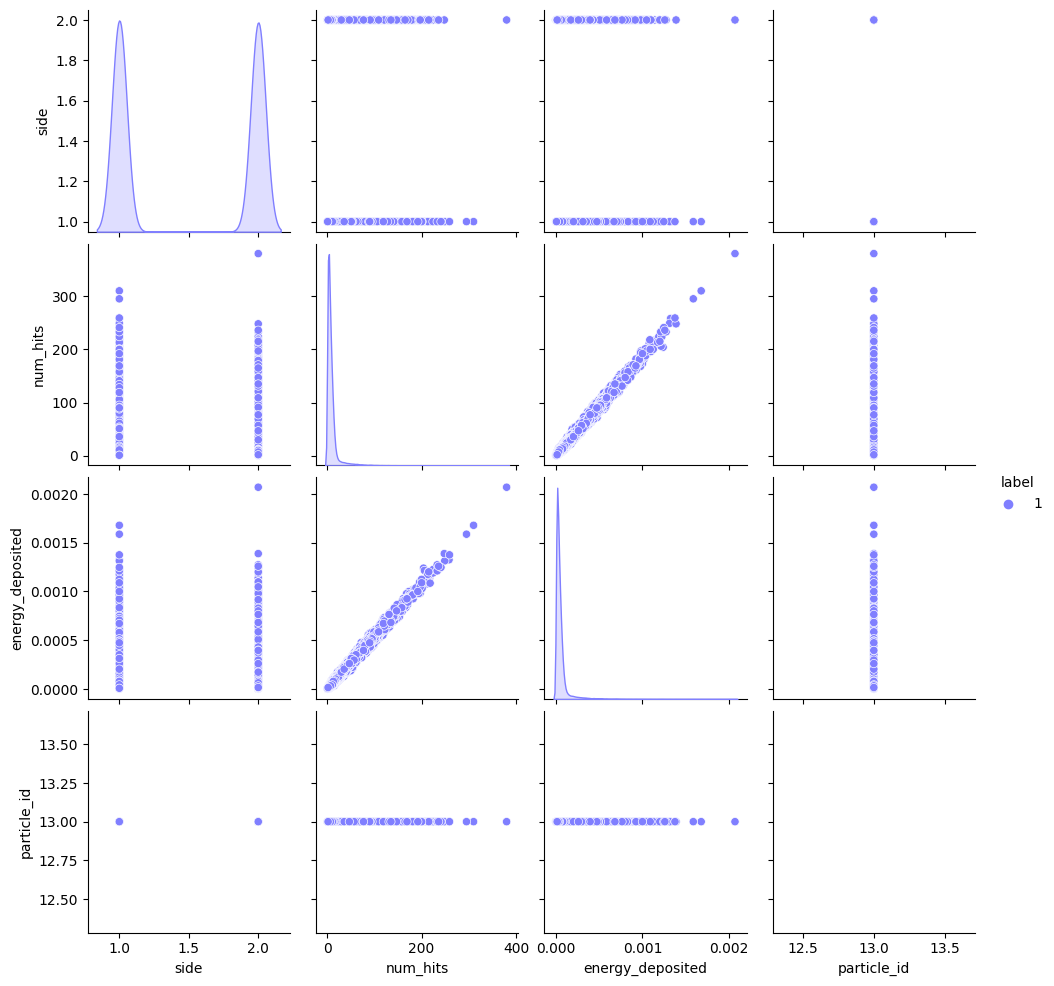

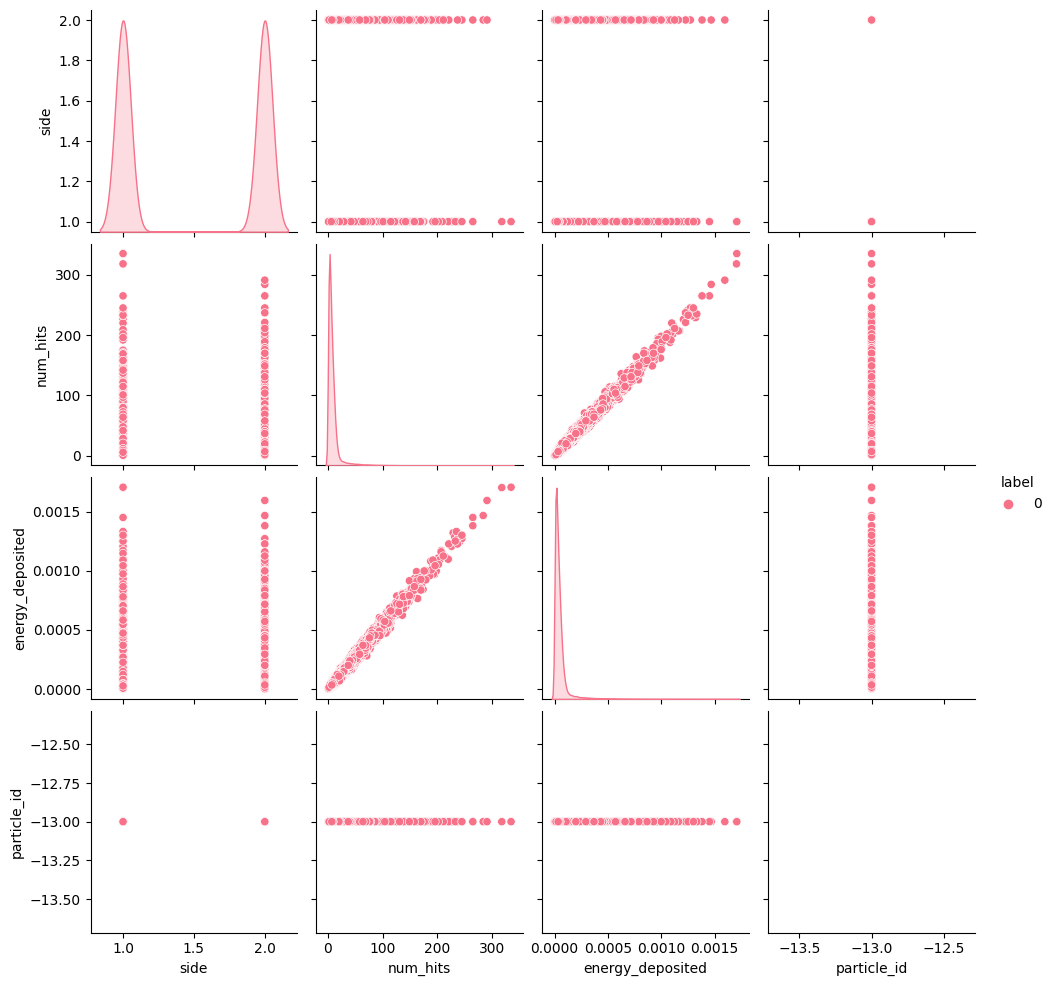

In [6]:
# Plot and compare the two datasets with different colors
sns.pairplot(df_MUM_03, hue='label', palette='cool')
sns.pairplot(df_MUP_03, hue='label', palette='husl')

In [7]:
# Exploratory data analysis comparing the two datasets
df_MUM_01.describe()

,side,num_hits,energy_deposited,particle_id,label
count,130043.000000,130043.000000,1.300430e+05,130043.0,130043.0
mean,1.497159,4.840253,2.656448e-05,13.0,1.0
std,0.499994,7.912493,4.305226e-05,0.0,0.0
min,1.000000,1.000000,1.874427e-07,13.0,1.0
25%,1.000000,1.000000,7.501964e-06,13.0,1.0
50%,1.000000,3.000000,1.431918e-05,13.0,1.0
75%,2.000000,5.000000,2.915285e-05,13.0,1.0
max,2.000000,177.000000,1.003403e-03,13.0,1.0


In [8]:
df_MUP_01.describe()

,side,num_hits,energy_deposited,particle_id,label
count,124760.000000,124760.000000,1.247600e+05,124760.0,124760.0
mean,1.500409,4.670760,2.567986e-05,-13.0,0.0
std,0.500002,7.688147,4.190073e-05,0.0,0.0
min,1.000000,1.000000,1.876388e-07,-13.0,0.0
25%,1.000000,1.000000,7.464783e-06,-13.0,0.0
50%,2.000000,2.000000,1.401884e-05,-13.0,0.0
75%,2.000000,5.000000,2.815806e-05,-13.0,0.0
max,2.000000,204.000000,1.120043e-03,-13.0,0.0


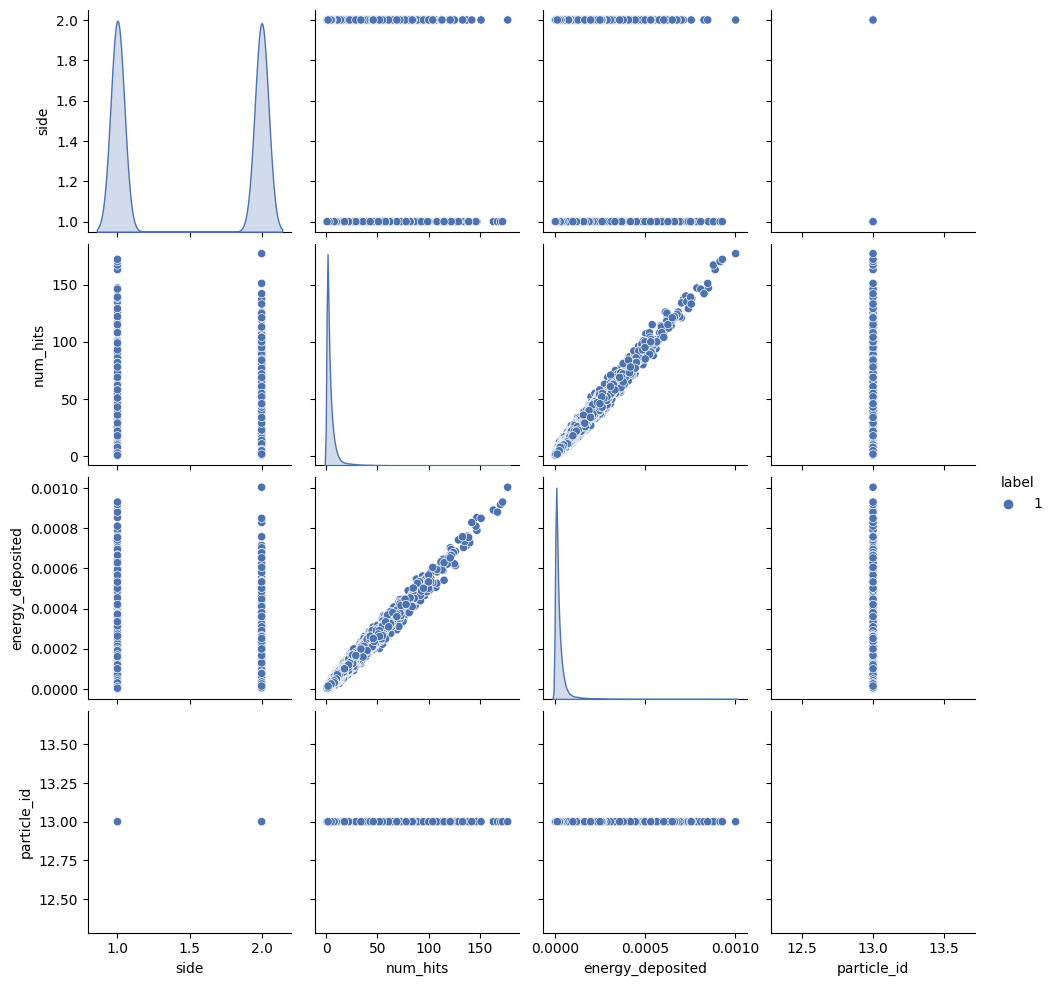

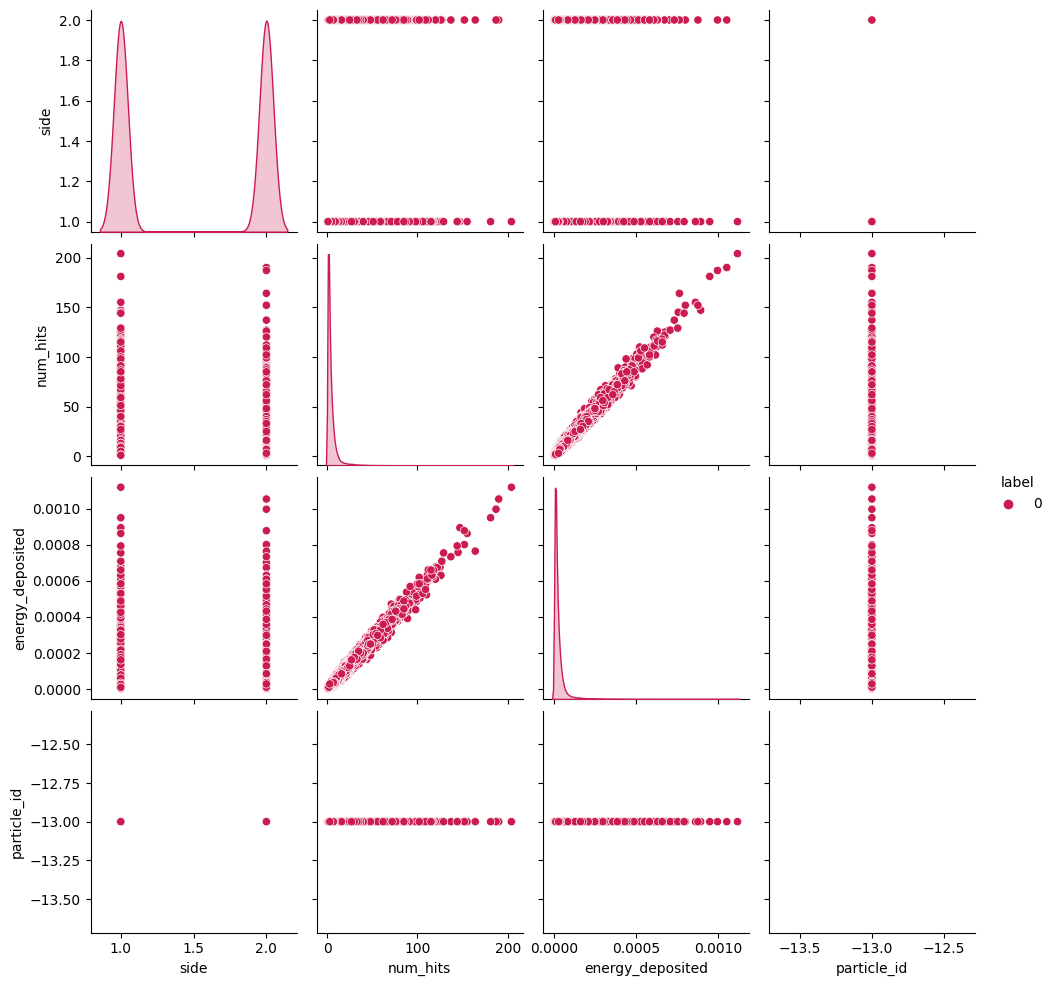

In [9]:
# Plot and compare the two datasets with different colors
sns.pairplot(df_MUM_01, hue='label', palette='deep')
sns.pairplot(df_MUP_01, hue='label', palette='rocket')

# Building X and y matrices

In [4]:
def reconstruct_matrix(filelist):
        # Declaration of a three-dimensional numpy matrix with two channels (side 1 and side 2) to give to a CNN.
        # The matrix will be filled with the energy deposited in each sparse coordinate (same coordinates as in the matrix).
        # The first channel is filled with the energy from the hits of the side 1 and the second channel is filled with the energy from hits of the side 2.
        
        X = []
        
        for file in filelist:
                with open(file) as f:
                        data = json.load(f)

                for event, event_data in data.items():
                        side_1 = event_data['gruid hits - side 1']
                        side_2 = event_data['gruid hits - side 2']
                        gruid_metadata = event_data['gruid metadata']
                        
                matrix = np.zeros((gruid_metadata['# of rows (y)'], gruid_metadata['# of columns (x)'], 2))
        
                # IMPORTANT: Coordinates are inverted in the matrix because of matrix notation in GRUID.
                        
                # Side 1
                for timestamp, timestamp_data in side_1.items():
                        for pixel, pixel_data in timestamp_data.items():
                                x, y = pixel.split(",")
                                matrix[ int(y), int(x), 0 ] = pixel_data['energy deposited']

                # Side 2
                for timestamp, timestamp_data in side_2.items():
                        for pixel, pixel_data in timestamp_data.items():
                                x, y = pixel.split(",")
                                matrix[ int(y), int(x), 1 ] = pixel_data['energy deposited']
                                                
                X.append(matrix)
                
        return np.array(X)
     
   
# 0.3 --------------------------------------------
muon_labels = np.ones(len(files_MUM_03))
antimuon_labels = np.zeros(len(files_MUP_03))
y_03 = np.concatenate((muon_labels, antimuon_labels))

muons = reconstruct_matrix(files_MUM_03)
antimuons = reconstruct_matrix(files_MUP_03)
X_03 = np.concatenate((muons, antimuons))

# 0.1 --------------------------------------------
muon_labels = np.ones(len(files_MUM_01))
antimuon_labels = np.zeros(len(files_MUP_01))
y_01 = np.concatenate((muon_labels, antimuon_labels))

muons = reconstruct_matrix(files_MUM_01)
antimuons = reconstruct_matrix(files_MUP_01)
X_01 = np.concatenate((muons, antimuons))

neutrons = reconstruct_matrix(files_NEU_03)
neutron_labels = np.ones(len(files_NEU_03))*2

## Saving Matrices to files

In [5]:
# Save matrices to file
np.save('matrices/X_03.npy', X_03)
np.save('matrices/y_03.npy', y_03)
np.save('matrices/X_01.npy', X_01)
np.save('matrices/y_01.npy', y_01)
np.save('matrices/nX.npy', neutrons)
np.save('matrices/ny.npy', neutron_labels)

# Code 💻

## Loading saved matrices 

In [21]:
# Load matrices from previously generated files
X_01 = np.load('matrices/X_01.npy')
y_01 = np.load('matrices/y_01.npy')
X_03 = np.load('matrices/X_03.npy')
y_03 = np.load('matrices/y_03.npy')
nX = np.load('matrices/nX.npy')
ny = np.load('matrices/ny.npy')

## Reviewing Shapes

In [22]:
print(X_03.shape, y_03.shape)
print(X_01.shape, y_01.shape)
print(nX.shape, ny.shape)

(10167, 7, 5, 2) (10167,)
(10233, 21, 15, 2) (10233,)
(14, 7, 5, 2) (14,)


In [23]:
# Make the 0.3 the standard dataset
X = X_03
y = y_03

## Splitting the data

In [45]:
# Splitting the data into training and testing sets
# We will use 80% of the data for training and 20% of the data for testing.
# We will use the function train_test_split from sklearn.model_selection to split the data.
# We will use the parameter stratify to split the data in a stratified way.
# We will split the training data into training and validation sets.
# We will use 80% of the training data for training and 20% of the training data for validation.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6548, 21, 15, 2),
 (1638, 21, 15, 2),
 (2047, 21, 15, 2),
 (6548,),
 (1638,),
 (2047,))

In [46]:
# Show target vector (1 = muon, 0 = antimuon)
print(y_train)

[1. 0. 1. ... 0. 1. 1.]


## 1D-CNN Approach

### Reshaping

In [30]:
# Splitting the data into training and testing sets
# We will use 80% of the data for training and 20% of the data for testing.
# We will use the function train_test_split from sklearn.model_selection to split the data.
# We will use the parameter stratify to split the data in a stratified way.
# We will split the training data into training and validation sets.
# We will use 80% of the training data for training and 20% of the training data for validation.

# Reshape X to fit the input of the 1D CNN
X = X.reshape((X.shape[0], -1, 1))
X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6548, 630, 1), (1638, 630, 1), (2047, 630, 1), (6548,), (1638,), (2047,))

In [31]:
# Show target vector (1 = muon, 0 = antimuon)
print(y_train)

[0. 0. 1. ... 1. 1. 1.]


### Normalizing

In [32]:
# Normalizing the data
# We will use the function normalize from keras.utils to normalize the data.
# We will normalize the data by dividing the data by the maximum value of the data.
X_train = keras.utils.normalize(X_train, axis=1)
X_val = keras.utils.normalize(X_val, axis=1)
X_test = keras.utils.normalize(X_test, axis=1)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6548, 630, 1), (1638, 630, 1), (2047, 630, 1), (6548,), (1638,), (2047,))

### CNN

In [35]:
# 1D CNN
# We will use a 1D CNN to classify the data.

def f1_score(precision, recall):
        return 2 * (precision * recall) / (precision + recall)

model = keras.models.Sequential([
        keras.layers.Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        keras.layers.MaxPooling1D(2),
        keras.layers.Conv1D(64, 3, activation='relu'),
        keras.layers.MaxPooling1D(2),
        keras.layers.Conv1D(128, 3, activation='relu'),
        keras.layers.MaxPooling1D(2),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='ROC'), 'accuracy', f1_score])

model.summary()

# Time the training
start = time.time()
history = model.fit(X_train, keras.utils.to_categorical(y_train), epochs=30, validation_data=(X_val, keras.utils.to_categorical(y_val)))
end = time.time()
print('Training time [s]:', end - start)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 628, 32)           128       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 314, 32)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 312, 64)           6208      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 156, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 154, 128)          24704     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 77, 128)         

### Plot

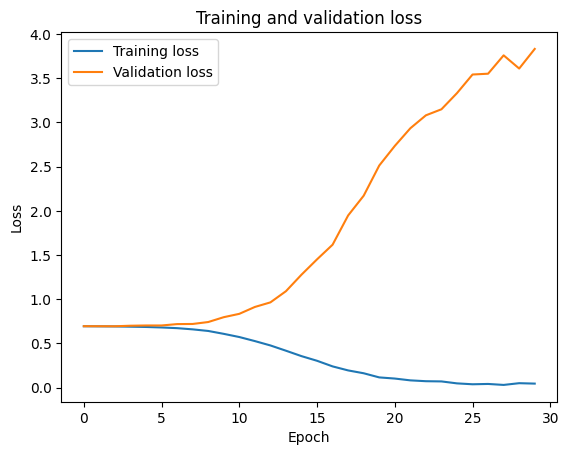

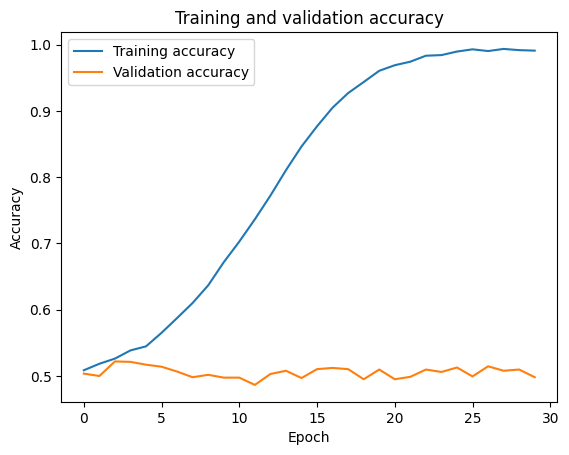

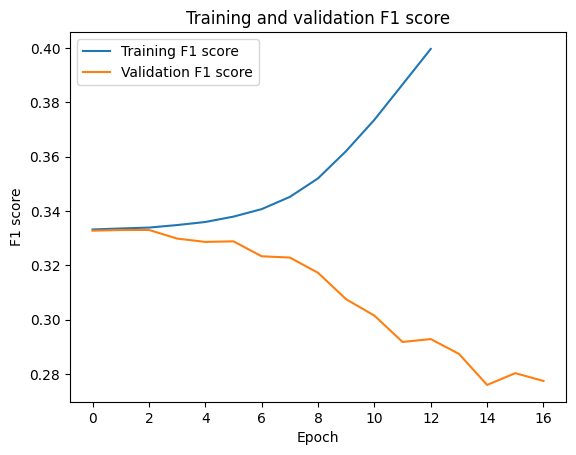

In [36]:
# Plotting the training and validation loss
# We will use the function plot from matplotlib.pyplot to plot the training and validation loss.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
# We will use the function plot from matplotlib.pyplot to plot the training and validation accuracy.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plotting F1 score
plt.plot(history.history['f1_score'], label='Training F1 score')
plt.plot(history.history['val_f1_score'], label='Validation F1 score')
plt.title('Training and validation F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend()
plt.show()


## Reshaping with the keras.smart_resize 32x32 CNN approach

### Reshape

In [47]:
# Making sure that the data is in the correct format for the CNN
# We will use the function reshape from numpy to reshape the data.
# We will reshape the data to have 4 dimensions. Parameter 1 will be the number of events, 2 and 3 will be the dimensions of the matrix and 4 will be the number of channels.
# Images are not square, so we will proportionally resize the images to be square.

# Dimensions to resize the images to
ROWS = 32
COLS = 32

X_train = np.array([keras.preprocessing.image.smart_resize(image, (ROWS, COLS)) for image in X_train])
X_val = np.array([keras.preprocessing.image.smart_resize(image, (ROWS, COLS)) for image in X_val])
X_test = np.array([keras.preprocessing.image.smart_resize(image, (ROWS, COLS)) for image in X_test])

# Normalizing the data
# We will use the function normalize from keras.utils to normalize the data.
# We will normalize the data by dividing the data by the maximum value of the data.
X_train = keras.utils.normalize(X_train, axis=1)
X_val = keras.utils.normalize(X_val, axis=1)
X_test = keras.utils.normalize(X_test, axis=1)

# Reshaping the target data to have 2 dimensions (one-hot encoding)
y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)
y_test = keras.utils.to_categorical(y_test, 2)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6548, 32, 32, 2),
 (1638, 32, 32, 2),
 (2047, 32, 32, 2),
 (6548, 2),
 (1638, 2),
 (2047, 2))

In [48]:
# Show target vector ([0,1] = muon, [1,0] = antimuon)
y_train

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### Pre-Plot

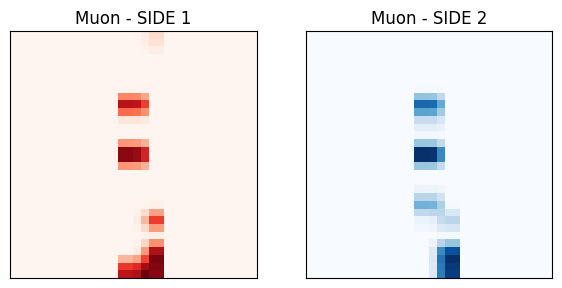

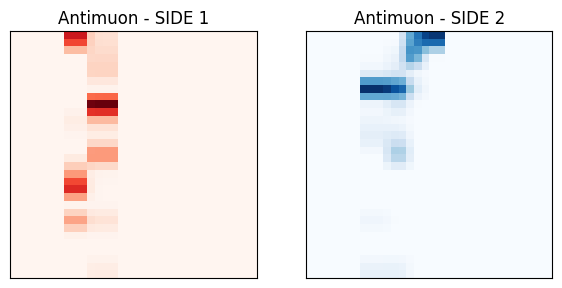

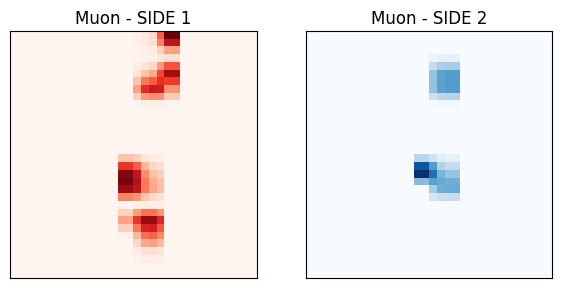

In [49]:
# Plotting a muon event
# We will plot a muon event from the training set.
# We will use the function imshow from matplotlib.pyplot to plot the event.
# We will use the parameter cmap to plot the two channels of the event with different colors.
# Plotting the two channels of the event with different colors with shared axis.
# Plot 3 random events from the training set.

random_events = np.random.randint(0, X_train.shape[0], 3)

for i in random_events:
        plt.figure(figsize=(7,7))
        plt.subplot(1,2,1)
        plt.imshow(X_train[i,:,:,0], cmap='Reds')
        plt.title('Muon - SIDE 1' if y_train[i][0] == 0 else 'Antimuon - SIDE 1')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2, sharex=plt.gca(), sharey=plt.gca())
        plt.imshow(X_train[i,:,:,1], cmap='Blues')
        plt.title('Muon - SIDE 2' if y_train[i][0] == 0 else 'Antimuon - SIDE 2')
        # Show tick labels on both sides
        plt.tick_params('x', labelbottom=True, labeltop=True)
        plt.tick_params('y', labelleft=True, labelright=True)
        
plt.show()

### CNN 1

In [50]:
# CNN
# We will use a CNN to classify the events.
# The input of the CNN will be a matrix with two channels (side 1 and side 2) with the energy deposited in each sparse coordinate.
# The output of the CNN will be a vector with two elements (one for each class).
# The CNN will have two convolutional layers, two max pooling layers and two dense layers.
# The first convolutional layer will have 32 filters and the second convolutional layer will have 64 filters.
# The first dense layer will have 64 neurons and the second dense layer will have 2 neurons (one for each class).
# The activation function of the first dense layer will be ReLU and the activation function of the second dense layer will be softmax.
# The loss function will be categorical crossentropy and the optimizer will be Adam.
# The metrics will be f1-score , precision, recall, AUC and accuracy.

def f1_score(precision, recall):
        return 2 * (precision * recall) / (precision + recall)

model_cpcp = keras.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
        ])

# Compile the model and build F1 score metric
model_cpcp.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              #metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='ROC'), 'accuracy', f1_score])

model_cpcp.summary()

# Time the training
start = time.time()
history_cpcp = model_cpcp.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
end = time.time()
print('Training time:', end - start)



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        608       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 2304)              0         
                                                                 
 dense_12 (Dense)            (None, 64)               

### Plot 1

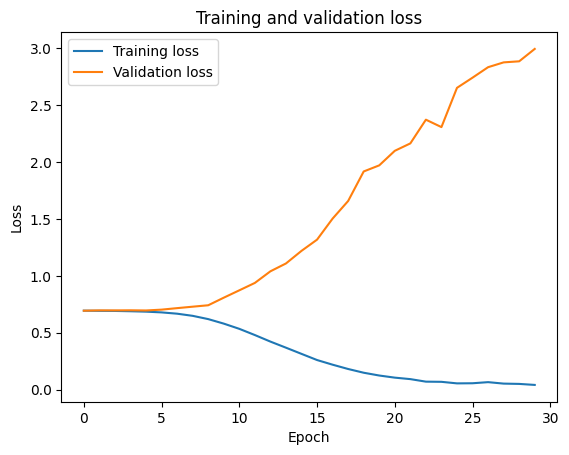

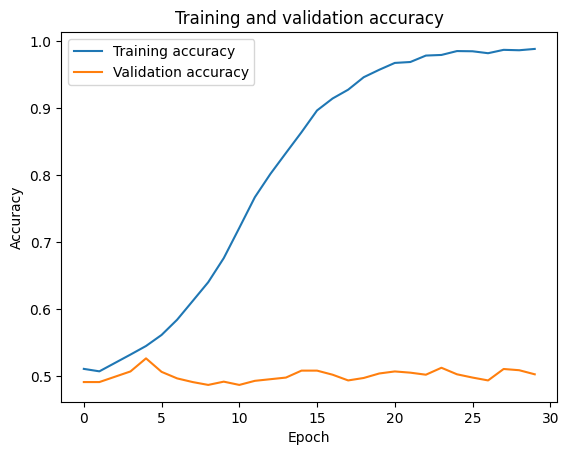

In [51]:
# Plotting the training and validation loss
# We will use the function plot from matplotlib.pyplot to plot the training and validation loss.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history_cpcp.history['loss'], label='Training loss')
plt.plot(history_cpcp.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
# We will use the function plot from matplotlib.pyplot to plot the training and validation accuracy.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history_cpcp.history['accuracy'], label='Training accuracy')
plt.plot(history_cpcp.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### CNN 2

In [52]:
# CNN
# We will use a CNN to classify the events.
# The input of the CNN will be a matrix with two channels (side 1 and side 2) with the energy deposited in each sparse coordinate.
# The output of the CNN will be a vector with two elements (one for each class).
# The CNN will have two convolutional layers, two max pooling layers and two dense layers.
# The first convolutional layer will have 32 filters, a kernel size of 3x3, a stride of 1x1 and a ReLU activation function.
# The first max pooling layer will have a pool size of 2x2 and a stride of 2x2.
# The second convolutional layer will have 64 filters, a kernel size of 3x3, a stride of 1x1 and a ReLU activation function.
# The second max pooling layer will have a pool size of 2x2 and a stride of 2x2.
# The first dense layer will have 128 neurons and a ReLU activation function.
# The second dense layer will have 2 neurons and a softmax activation function.
# We will use the Adam optimizer with a learning rate of 0.001.
# We will use the categorical crossentropy loss function.
# We will use the accuracy metric.
# We will train the CNN for 10 epochs with a batch size of 32.

# Create the CNN

def f1_score(precision, recall):
        return 2 * (precision * recall) / (precision + recall)

model = keras.models.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
])

# Compile the CNN
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
              #metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='ROC'), 'accuracy', f1_score])

model.summary()

# Time the training
start = time.time()
history = model.fit(X_train, y_train, epochs=70, validation_data=(X_val, y_val))
end = time.time()
print('Training time:', end - start)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        608       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 2304)              0         
                                                                 
 dense_14 (Dense)            (None, 128)              

### Plot 2

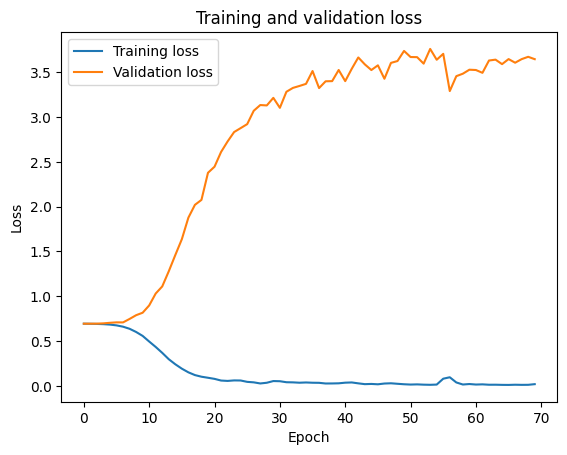

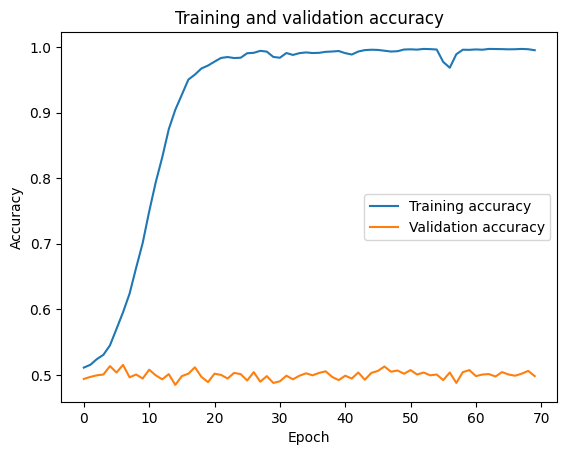

In [53]:
# Plotting the training and validation loss
# We will use the function plot from matplotlib.pyplot to plot the training and validation loss.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
# We will use the function plot from matplotlib.pyplot to plot the training and validation accuracy.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Feed-Forward Approach

### Reshape

In [40]:
# Normalizing the data
# We will use the function normalize from keras.utils to normalize the data.
# We will normalize the data by dividing the data by the maximum value of the data.
X_train = keras.utils.normalize(X_train, axis=1)
X_val = keras.utils.normalize(X_val, axis=1)
X_test = keras.utils.normalize(X_test, axis=1)

# Reshape the data for a fit forward neural networ
# Reshape the y data to be a column one-hot encoded vector.
y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)
y_test = keras.utils.to_categorical(y_test, 2)

### FFNN

In [42]:
# Trying with a different approach
# We will use a Feed-forward Neural Network to classify the events.
# The input of the Fit-forward Neural Network will be a matrix with two channels (side 1 and side 2) with the energy deposited in each sparse coordinate.
# The output of the Fit-forward Neural Network will be a vector with two elements (one for each class).
# The Fit-forward Neural Network will have two dense layers.
# The first dense layer will have 64 neurons and the second dense layer will have 2 neurons (one for each class).
# The activation function of the first dense layer will be ReLU and the activation function of the second dense layer will be softmax.
# The loss function will be categorical crossentropy and the optimizer will be Adam.
# The metrics will be f1-score , precision, recall, AUC and accuracy.

def f1_score(precision, recall):
        return 2 * (precision * recall) / (precision + recall)

model = keras.Sequential([
        keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        keras.layers.Dense(2, activation='softmax')
        ])

# Compile the model and build F1 score metric
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              #metrics=['accuracy'])
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='ROC'), 'accuracy', f1_score])

model.summary()

# Time the training
start = time.time()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
end = time.time()
print('Training time:', end - start)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 630)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                 1262      
                                                                 
Total params: 1,262
Trainable params: 1,262
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
205/205 [==============================] - 3s 6ms/step - loss: 0.6956 - precision_4: 0.5008 - recall_4: 0.5008 - auc_8: 0.5054 - auc_9: 0.5054 - accuracy: 0.5008 - f1_score: 0.3331 - val_loss: 0.6970 - val_precision_4: 0.4951 - val_recall_4: 0.4951 - val_auc_8: 0.4912 - val_auc_9: 0.4912 - val_accuracy: 0.4951 - val_f1_score: 0.3327
Epoch 2/30
205/205 [==============================] - 1s 4ms/step - loss: 0.6898 - precision_4: 0.5299

### FF Plot

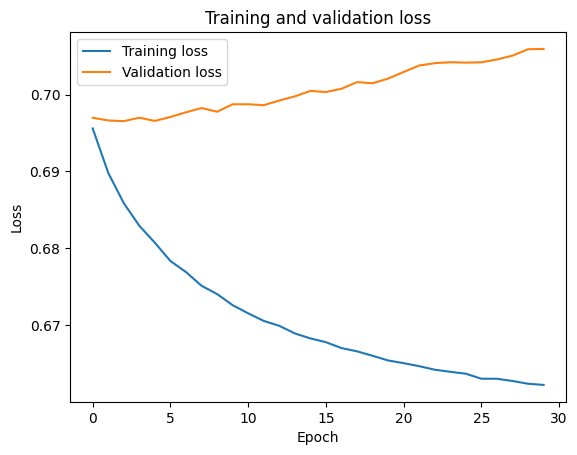

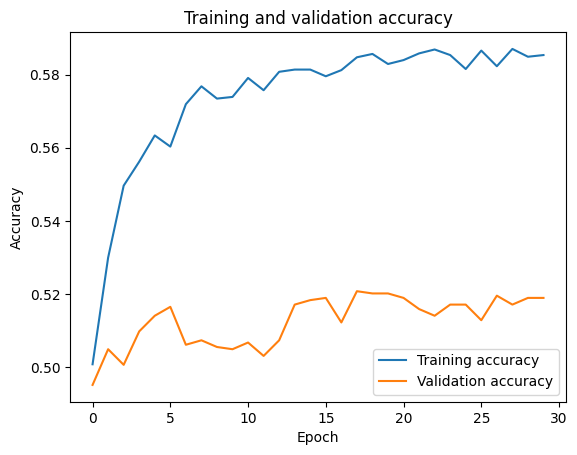

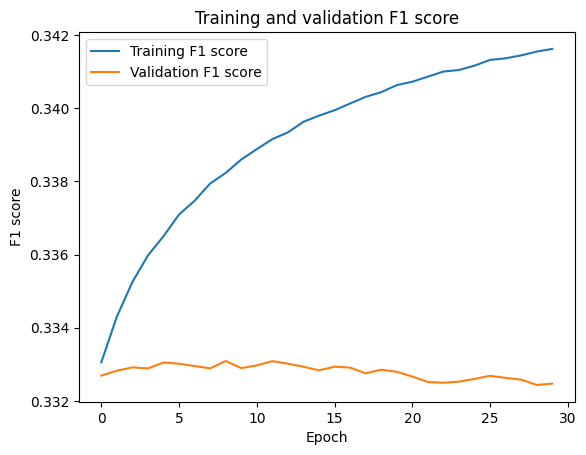

In [43]:
# Plotting the training and validation loss
# We will use the function plot from matplotlib.pyplot to plot the training and validation loss.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
# We will use the function plot from matplotlib.pyplot to plot the training and validation accuracy.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting F1 score
plt.plot(history.history['f1_score'], label='Training F1 score')
plt.plot(history.history['val_f1_score'], label='Validation F1 score')
plt.title('Training and validation F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend()
plt.show()


## Reshaping with np.pad with zeros for a 21x21 CNN aproach

### Reshape

In [17]:
# We want to bring the dimension from each matrix from 21,15,2 to 21,21,2.
# We will use numpy.pad to pad the matrices with zeros.
# We will pad the matrices with zeros in the third dimension (columns) and calculate the necessary padding for each matrix.

X_train = np.pad(X_train, ((0,0),(0,0),(0, X_train.shape[1]-X_train.shape[2]), (0,0)), mode='constant')
X_val = np.pad(X_val, ((0,0),(0,0),(0, X_val.shape[1]-X_val.shape[2]), (0,0)), mode='constant')
X_test = np.pad(X_test, ((0,0),(0,0),(0, X_test.shape[1]-X_test.shape[2]), (0,0)), mode='constant')

# Normalizing the data
# We will use the function normalize from keras.utils to normalize the data.
# We will normalize the data by dividing the data by the maximum value of the data.
X_train = keras.utils.normalize(X_train, axis=1)
X_val = keras.utils.normalize(X_val, axis=1)
X_test = keras.utils.normalize(X_test, axis=1)

# Reshape the y data to be a column one-hot encoded vector.
y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)
y_test = keras.utils.to_categorical(y_test, 2)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6548, 21, 21, 2),
 (1638, 21, 21, 2),
 (2047, 21, 21, 2),
 (6548, 2),
 (1638, 2),
 (2047, 2))

In [18]:
# Show target vector ([0,1] = muon, [1,0] = antimuon)
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### Plot events

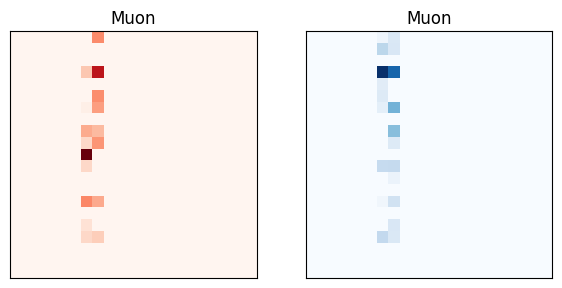

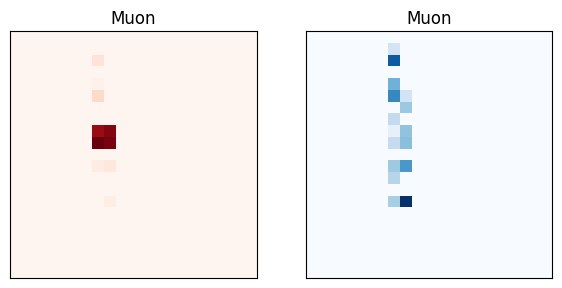

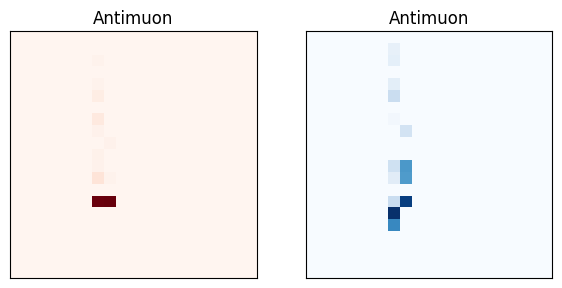

In [19]:
# Plotting a muon event
# We will plot a muon event from the training set.
# We will use the function imshow from matplotlib.pyplot to plot the event.
# We will use the parameter cmap to plot the two channels of the event with different colors.
# Plotting the two channels of the event with different colors with shared axis.
# Plot 3 random events from the training set.

random_events = np.random.randint(0, X_train.shape[0], 3)

for i in random_events:
        plt.figure(figsize=(7,7))
        plt.subplot(1,2,1)
        plt.imshow(X_train[i,:,:,0], cmap='Reds')
        plt.title('Muon' if y_train[i][0] == 0 else 'Antimuon')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2, sharex=plt.gca(), sharey=plt.gca())
        plt.imshow(X_train[i,:,:,1], cmap='Blues')
        plt.title('Muon' if y_train[i][0] == 0 else 'Antimuon')
        # Show tick labels on both sides
        plt.tick_params('x', labelbottom=True, labeltop=True)
        plt.tick_params('y', labelleft=True, labelright=True)
        
plt.show()
        

### CNN

In [23]:
# CNN
# We will use a CNN to classify the events.
# The input of the CNN will be a matrix with two channels (side 1 and side 2) with the energy deposited in each sparse coordinate.
# The output of the CNN will be a vector with two elements (one for each class).
# The CNN will have two convolutional layers, two max pooling layers and two dense layers.
# The first convolutional layer will have 32 filters of size 3x3.
# The second convolutional layer will have 64 filters of size 3x3.
# The first max pooling layer will have a pool size of 2x2.
# The second max pooling layer will have a pool size of 2x2.
# The first dense layer will have 128 neurons.
# The second dense layer will have 2 neurons.

def f1_score(precision, recall):
        return 2 * (precision * recall) / (precision + recall)


# Create the CNN
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))

# Compile the model and build F1 score metric
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              #metrics=['accuracy'])
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='ROC'), 'accuracy', f1_score])

model.summary()

# Time the training
start = time.time()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
end = time.time()
print('Training time:', end - start)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 19, 19, 32)        608       
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 128)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1152)             

### Plot

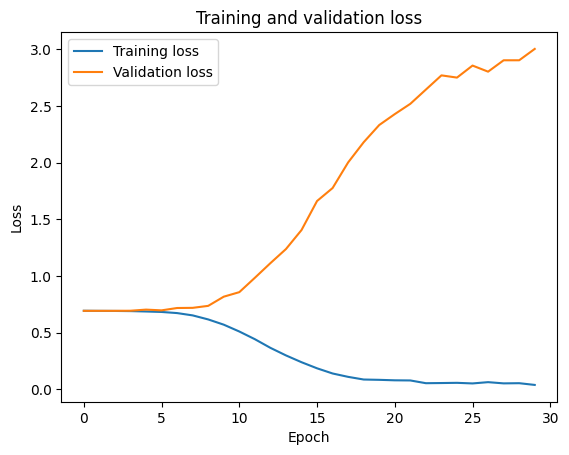

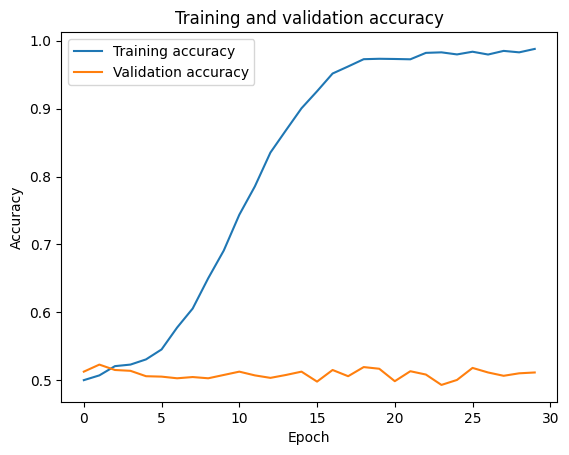

In [24]:
# Plotting the training and validation loss
# We will use the function plot from matplotlib.pyplot to plot the training and validation loss.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
# We will use the function plot from matplotlib.pyplot to plot the training and validation accuracy.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Auto-Encoder Approach

### Train test split

In [26]:
# Use the matrices to train the model, we will train an autoencoder for the muon events.
# Train test split

# Muons --------------------------------------------------------------
print('Muons')
# Use X and y to recover the muon events
muons = X[y == 1]
muon_labels = y[y == 1]

# Create an imbalanced dataset with 5% of antimuon events shuffling the muon events with the antimuon events
#X_shuffled = np.concatenate((muons, antimuons[:int(0.05 * antimuons.shape[0])]), axis=0)
#y_shuffled = np.concatenate((muon_labels, antimuon_labels[:int(0.05 * antimuons.shape[0])]), axis=0)

X_train, X_test, y_train, y_test = train_test_split(muons, muon_labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Normalizing the data
# We will use the function normalize from keras.utils to normalize the data.
# We will normalize the data by dividing the data by the maximum value of the data.
X_train = keras.utils.normalize(X_train, axis=1)
X_val = keras.utils.normalize(X_val, axis=1)
X_test = keras.utils.normalize(X_test, axis=1)

# Reshape the y data to be a column one-hot encoded vector.
y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)
y_test = keras.utils.to_categorical(y_test, 2)

# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
#print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")
print(f"Muon shapes: {X_train.shape}, {X_val.shape}, {X_test.shape}, {y_train.shape}, {y_val.shape}, {y_test.shape}")
# Show target vector (1 = muon, 0 = antimuon)
print(f"Muon target training vector: {y_train}")

# Antimuons --------------------------------------------------------------
print('Antimuons')
# Use X and y to recover the antimuon events
antimuons = X[y == 0]
antimuon_labels = y[y == 0]

# Train test split for antimuon data
aX_train, aX_test, ay_train, ay_test = train_test_split(antimuons, antimuon_labels, test_size=0.2)
aX_train, aX_val, ay_train, ay_val = train_test_split(aX_train, ay_train, test_size=0.2)

# Normalizing the data
# We will use the function normalize from keras.utils to normalize the data.
# We will normalize the data by dividing the data by the maximum value of the data.
aX_train = keras.utils.normalize(aX_train, axis=1)
aX_val = keras.utils.normalize(aX_val, axis=1)
aX_test = keras.utils.normalize(aX_test, axis=1)

ay_train = keras.utils.to_categorical(ay_train, 2)
ay_val = keras.utils.to_categorical(ay_val, 2)
ay_test = keras.utils.to_categorical(ay_test, 2)

# Check the number of records
print('The number of records in the training dataset is', aX_train.shape[0])
print('The number of records in the test dataset is', aX_test.shape[0])
print(f"Antimuon shapes: {aX_train.shape, aX_val.shape, aX_test.shape, ay_train.shape, ay_val.shape, ay_test.shape}")

# Neutrons --------------------------------------------------------------
print('Neutrons')
# Normalizing the data
nX = keras.utils.normalize(nX, axis=1)
print(f"Neutron shapes: {nX.shape, ny.shape}")


Muons
The number of records in the training dataset is 3322
The number of records in the test dataset is 1039
Muon shapes: (3322, 7, 5, 2), (831, 7, 5, 2), (1039, 7, 5, 2), (3322, 2), (831, 2), (1039, 2)
Muon target training vector: [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Antimuons
The number of records in the training dataset is 3184
The number of records in the test dataset is 995
Antimuon shapes: ((3184, 7, 5, 2), (796, 7, 5, 2), (995, 7, 5, 2), (3184, 2), (796, 2), (995, 2))
Neutrons
Neutron shapes: ((14, 7, 5, 2), (14,))


### Plot events

[3286]


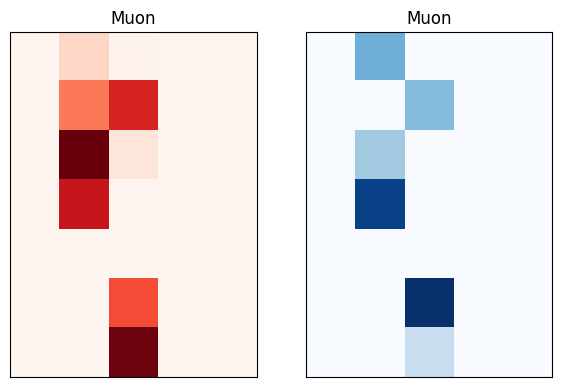

In [9]:
# Plotting a muon event
# We will plot a muon event from the training set.
# We will use the function imshow from matplotlib.pyplot to plot the event.
# We will use the parameter cmap to plot the two channels of the event with different colors.
# Plotting the two channels of the event with different colors with shared axis.
# Plot 3 random events from the training set.

random_events = np.random.randint(0, X_train.shape[0], 1)
print(random_events)

for i in random_events:
        plt.figure(figsize=(7,7))
        plt.subplot(1,2,1)
        plt.imshow(X_train[i,:,:,0], cmap='Reds')
        plt.title('Muon' if y_train[i][0] == 0 else 'Antimuon')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2, sharex=plt.gca(), sharey=plt.gca())
        plt.imshow(X_train[i,:,:,1], cmap='Blues')
        plt.title('Muon' if y_train[i][0] == 0 else 'Antimuon')
        # Show tick labels on both sides
        plt.tick_params('x', labelbottom=True, labeltop=True)
        plt.tick_params('y', labelleft=True, labelright=True)
        
plt.show()

### Autoencoder 1

In [10]:
# Step 4: Design Autoencoder Algorithm For Anomaly Detection
        # The autoencoder model for anomaly detection has six steps. The first three steps are for model training, and the last three steps are for model prediction.
        # Step 1 is the encoder step. The essential information is extracted by a neural network model in this step.
        # Step 2 is the decoder step. In this step, the model reconstructs the data using the extracted information.
        # Step 3: Iterate step 1 and step 2 to adjust the model to minimize the difference between input and reconstructed output, until we get good reconstruction results for the training dataset.
        # Step 4: Make predictions on a dataset that includes outliers.
        # Step 5: Set up a threshold for outliers/anomalies by comparing the differences between the autoencoder model reconstruction value and the actual value.
        # Step 6: Identify the data points with a difference higher than the threshold to be outliers or anomalies.

In [47]:
# Step 5: Autoencoder Model Training
# The encoder consists of 3 layers with 16, 8, and 4 neurons, respectively. Note that the encoder requires the number of neurons to decrease with the layers. The last layer in the encoder is the size of the encoded representation, and it is also called the bottleneck.
# The decoder consists of 3 layers with 8, 16, and 32 neurons, respectively. Opposite the encoder, the decoder requires the number of neurons to increase with the layers. The output layer in the decoder has the same size as the input layer.

# Keep only the normal data for the training dataset
#X_train_normal = X_train[np.where(y_train == 0)]

print(X_train.shape)
MATRIX_SHAPE = X_train.shape[1:]
print(MATRIX_SHAPE)

# Input layer: the input are images with two channels (side 1 and side 2), each image has a 7x5 resolution (7,5,2)
input = tf.keras.layers.Input(shape=(MATRIX_SHAPE))
activation_function = "sigmoid"

# Encoder layers
encoder = tf.keras.Sequential([
  layers.Flatten(),
  layers.Dense(np.prod(MATRIX_SHAPE), activation=activation_function),
  layers.Dense(35, activation=activation_function),
  layers.Dense(7, activation=activation_function),
  layers.Dense(5, activation=activation_function)])(input)

# Decoder layers
decoder = tf.keras.Sequential([
      layers.Dense(5, activation=activation_function),
      layers.Dense(7, activation=activation_function),
      layers.Dense(35, activation=activation_function),
      layers.Dense(np.prod(MATRIX_SHAPE), activation=activation_function),
      layers.Reshape(MATRIX_SHAPE)])(encoder)

# Create the autoencoder
autoencoder = Model(input, decoder)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Fit the autoencoder
start = time.time()
history = autoencoder.fit(X_train, X_train, 
          epochs=30, 
          validation_data=(X_val, X_val),
          shuffle=True)
end = time.time()
print('Training time:', end - start)


(3322, 7, 5, 2)
(7, 5, 2)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7, 5, 2)]         0         
                                                                 
 sequential_4 (Sequential)   (None, 5)                 7747      
                                                                 
 sequential_5 (Sequential)   (None, 7, 5, 2)           2872      
                                                                 
Total params: 10,619
Trainable params: 10,619
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
104/104 [==============================] - 2s 4ms/step - loss: 0.1033 - val_loss: 0.0483
Epoch 2/30
104/104 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0369
Epoch 3/30
104/104 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 

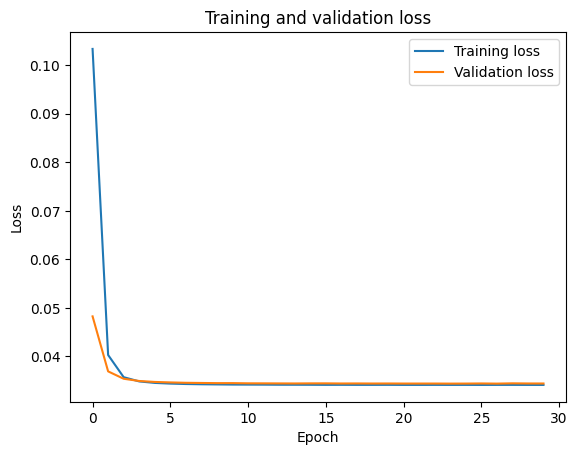

In [48]:

# Plotting the training and validation loss
# We will use the function plot from matplotlib.pyplot to plot the training and validation loss.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 25ms/step


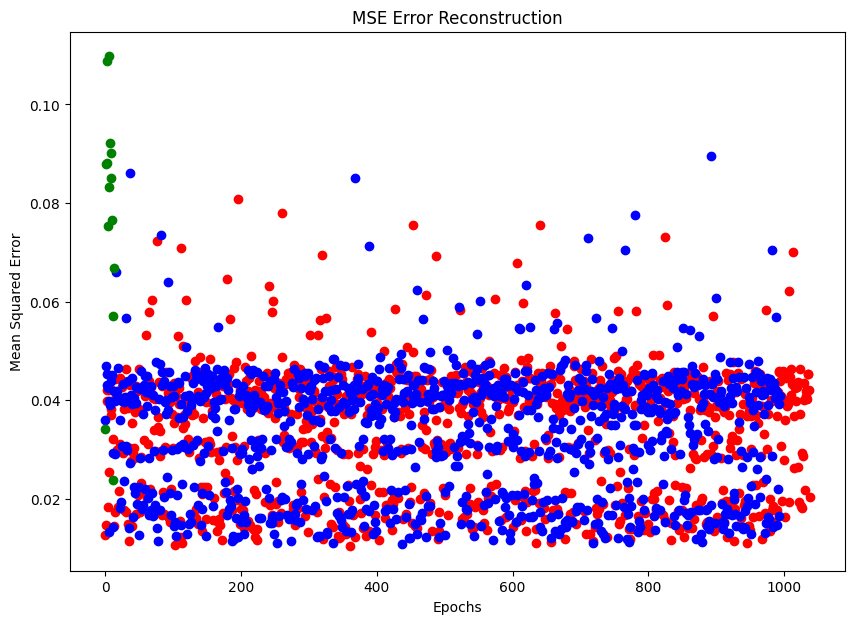

In [49]:
# Plot the difference between the input and the reconstructed output, we want to make sure that data is not separable so we feed the antimuon data to the autoencoder.
# We expect the reconstructed output caused by antimuon data to be non differentiable from the input.

# Train test split for antimuon data
aX_train, aX_test, ay_train, ay_test = train_test_split(antimuons, antimuon_labels, test_size=0.2)
aX_train, aX_val, ay_train, ay_val = train_test_split(aX_train, ay_train, test_size=0.2)

# Normalizing the data
# We will use the function normalize from keras.utils to normalize the data.
# We will normalize the data by dividing the data by the maximum value of the data.
aX_train = keras.utils.normalize(aX_train, axis=1)
aX_val = keras.utils.normalize(aX_val, axis=1)
aX_test = keras.utils.normalize(aX_test, axis=1)

# Train test split for neutron data
#nX_train, nX_test, ny_train, ny_test = train_test_split(neutrons, neutron_labels, test_size=0.2)
#nX_train, nX_val, ny_train, ny_val = train_test_split(nX_train, ny_train, test_size=0.2)

# Normalizing the data
nX = keras.utils.normalize(nX, axis=1)

X_test_pred = autoencoder.predict(X_test)
aX_test_pred = autoencoder.predict(aX_test)
nX_test_pred = autoencoder.predict(nX)

X_test_pred_mse_loss = tf.keras.losses.mse(X_test_pred, X_test)
aX_test_pred_mse_loss = tf.keras.losses.mse(aX_test_pred, aX_test)
nX_test_pred_mse_loss = tf.keras.losses.mse(nX_test_pred, nX)

X_test_pred_mse_loss = np.mean(X_test_pred_mse_loss, axis=(1,2))
aX_test_pred_mse_loss = np.mean(aX_test_pred_mse_loss, axis=(1,2))
nX_test_pred_mse_loss = np.mean(nX_test_pred_mse_loss, axis=(1,2))

plt.figure(figsize=(10, 7))
plt.scatter(range(len(X_test_pred_mse_loss)), X_test_pred_mse_loss, color='red', label='Reconstruction loss muons')
plt.scatter(range(len(aX_test_pred_mse_loss)), aX_test_pred_mse_loss, color='blue', label='Reconstruction loss antimuons')
plt.scatter(range(len(nX_test_pred_mse_loss)), nX_test_pred_mse_loss, color='green', label='Reconstruction loss neutrons')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE Error Reconstruction')
plt.show()


[619]


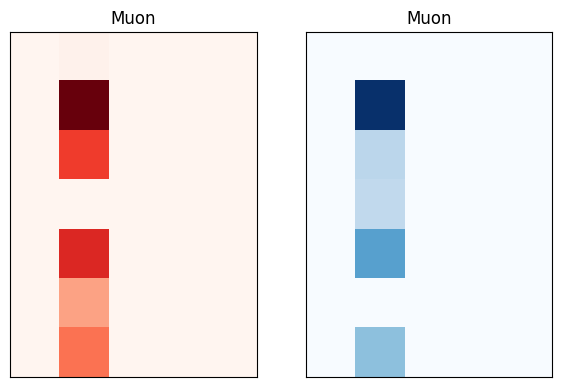

In [58]:
# Plotting a muon event and its reconstruction
# We will plot a muon event from the training set and its reconstruction from the autoencoder.

random_events = np.random.randint(0, X_test.shape[0], 1)
print(random_events)

for i in random_events:
        plt.figure(figsize=(7,7))
        plt.subplot(1,2,1)
        
        # Event
        plt.imshow(X_test[i,:,:,0], cmap='Reds')
        plt.title('Muon' if y_test[i][0] == 0 else 'Antimuon')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2, sharex=plt.gca(), sharey=plt.gca())
        plt.imshow(X_test[i,:,:,1], cmap='Blues')
        plt.title('Muon' if y_test[i][0] == 0 else 'Antimuon')
        
        # Show tick labels on both sides
        plt.tick_params('x', labelbottom=True, labeltop=True)
        plt.tick_params('y', labelleft=True, labelright=True)
        
plt.show()

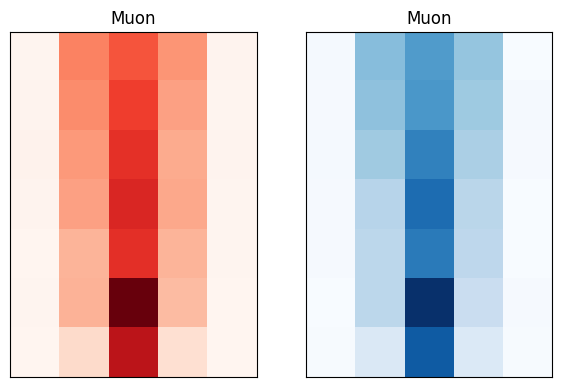

In [59]:

for i in random_events:
        plt.figure(figsize=(7,7))
        plt.subplot(1,2,1)
        
        # Recostructed event
        plt.imshow(X_test_pred[i,:,:,0], cmap='Reds')
        plt.title('Muon' if y_test[i][0] == 0 else 'Antimuon')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2, sharex=plt.gca(), sharey=plt.gca())
        plt.imshow(X_test_pred[i,:,:,1], cmap='Blues')
        plt.title('Muon' if y_test[i][0] == 0 else 'Antimuon')
        
        # Show tick labels on both sides
        plt.tick_params('x', labelbottom=True, labeltop=True)
        plt.tick_params('y', labelleft=True, labelright=True)
        
plt.show()

        

### Autoencoder 2

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 7, 5, 2)]         0         
                                                                 
 sequential_4 (Sequential)   (None, 32)                2272      
                                                                 
 sequential_5 (Sequential)   (None, 7, 5, 2)           2310      
                                                                 
Total params: 4,582
Trainable params: 4,582
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
104/104 [==============================] - 1s 4ms/step - loss: 0.0431 - accuracy: 0.5089 - val_loss: 0.0260 - val_accuracy: 0.5269
Epoch 2/30
104/104 [==============================] - 0s 3ms/step - loss: 0.0197 - accuracy: 0.5402 - val_loss: 0.0153 - val_accuracy: 0.5560
Epoch 3/30
104/104 [============

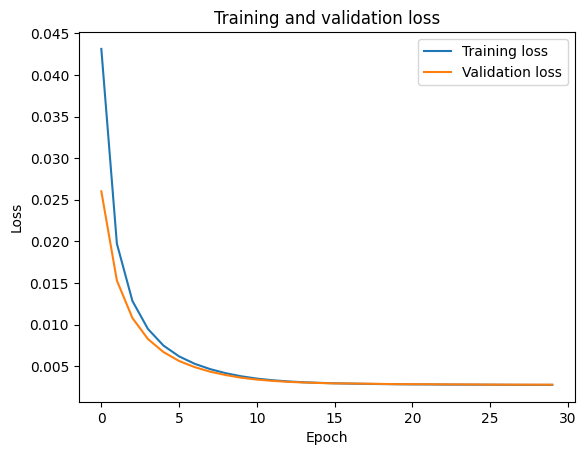

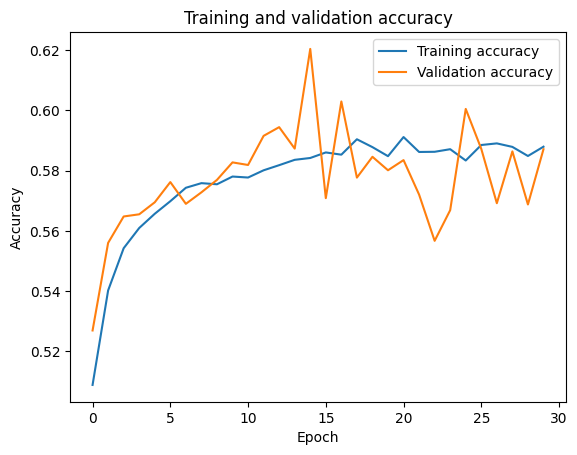

In [27]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 7*5*2, it's more generic than saying 70
    decoder.add(Reshape(img_shape))

    return encoder, decoder

MATRIX_SHAPE = X_train.shape[1:]
encoder, decoder = build_autoencoder(MATRIX_SHAPE, 32)

inp = Input(MATRIX_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile(optimizer='adam', loss='mse', metrics="accuracy")
print(autoencoder.summary())

# Fit the autoencoder
start = time.time()
history = autoencoder.fit(X_train, X_train, 
          epochs=30, 
          validation_data=(X_val, X_val),
          shuffle=True)
end = time.time()
print('Training time:', end - start)

# Plotting the training and validation loss
# We will use the function plot from matplotlib.pyplot to plot the training and validation loss.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
# We will use the function plot from matplotlib.pyplot to plot the training and validation accuracy.
# We will use the function title from matplotlib.pyplot to add a title to the plot.

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 23ms/step


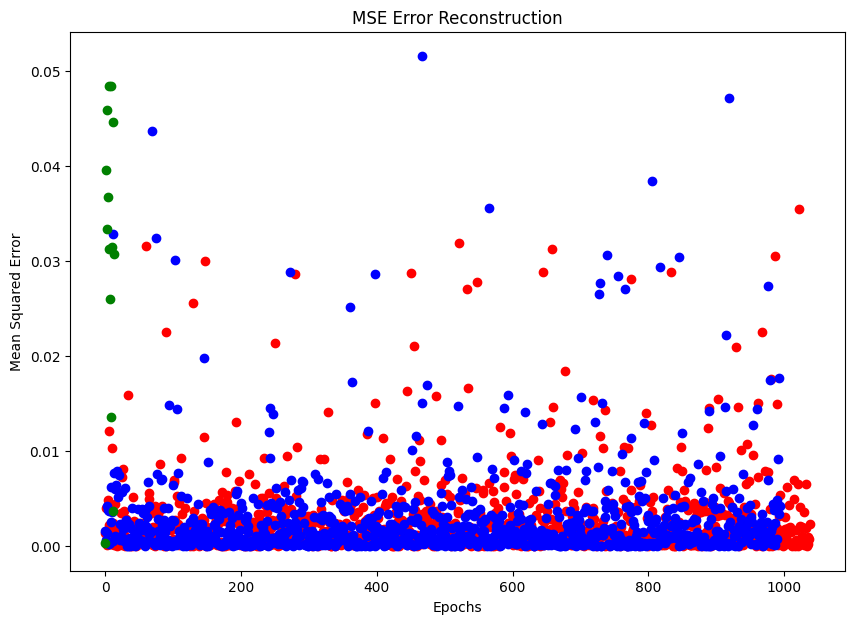

In [45]:
# Plot the difference between the input and the reconstructed output, we want to make sure that data is not separable so we feed the antimuon data to the autoencoder.
# We expect the reconstructed output caused by antimuon data to be non differentiable from the input.

X_test_pred = autoencoder.predict(X_test)
aX_test_pred = autoencoder.predict(aX_test)
nX_pred = autoencoder.predict(nX)

X_test_pred_mse_loss = tf.keras.losses.mse(X_test_pred, X_test)
aX_test_pred_mse_loss = tf.keras.losses.mse(aX_test_pred, aX_test)
nX_pred_mse_loss = tf.keras.losses.mse(nX_pred, nX)

X_test_pred_mse_loss = np.mean(X_test_pred_mse_loss, axis=(1,2))
aX_test_pred_mse_loss = np.mean(aX_test_pred_mse_loss, axis=(1,2))
nX_pred_mse_loss = np.mean(nX_pred_mse_loss, axis=(1,2))

plt.figure(figsize=(10, 7))
plt.scatter(range(len(X_test_pred_mse_loss)), X_test_pred_mse_loss, color='red', label='Reconstruction loss muons')
plt.scatter(range(len(aX_test_pred_mse_loss)), aX_test_pred_mse_loss, color='blue', label='Reconstruction loss antimuons')
plt.scatter(range(len(nX_pred_mse_loss)), nX_pred_mse_loss, color='green', label='Reconstruction loss neutrons')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE Error Reconstruction')
plt.show()


### Muon event

[698]


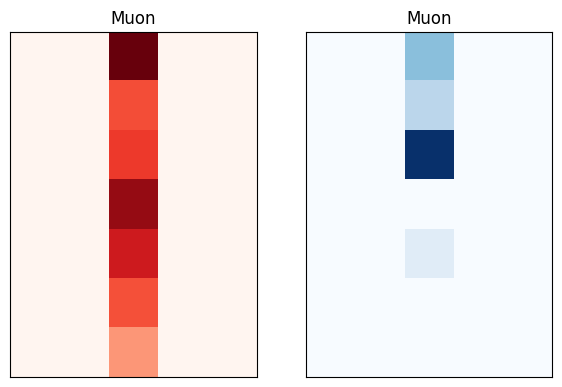

In [29]:
# Plotting a muon event and its reconstruction
# We will plot a muon event from the training set and its reconstruction from the autoencoder.

random_events = np.random.randint(0, X_test.shape[0], 1)
print(random_events)

for i in random_events:
        plt.figure(figsize=(7,7))
        plt.subplot(1,2,1)
        
        # Event
        plt.imshow(X_test[i,:,:,0], cmap='Reds')
        plt.title('Muon' if y_test[i][0] == 0 else 'Antimuon')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2, sharex=plt.gca(), sharey=plt.gca())
        plt.imshow(X_test[i,:,:,1], cmap='Blues')
        plt.title('Muon' if y_test[i][0] == 0 else 'Antimuon')
        
        # Show tick labels on both sides
        plt.tick_params('x', labelbottom=True, labeltop=True)
        plt.tick_params('y', labelleft=True, labelright=True)
        
plt.show()

### Reconstructed Muon event

[698]


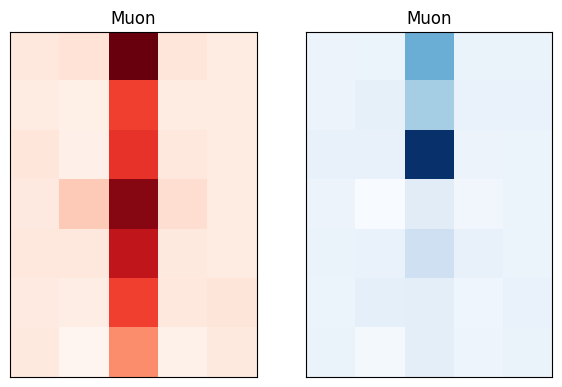

In [35]:
print(random_events)
for i in random_events:
        plt.figure(figsize=(7,7))
        plt.subplot(1,2,1)
        
        # Recostructed event
        plt.imshow(X_test_pred[i,:,:,0], cmap='Reds')
        plt.title('Muon' if y_test[i][0] == 0 else 'Antimuon')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2, sharex=plt.gca(), sharey=plt.gca())
        plt.imshow(X_test_pred[i,:,:,1], cmap='Blues')
        plt.title('Muon' if y_test[i][0] == 0 else 'Antimuon')
        
        # Show tick labels on both sides
        plt.tick_params('x', labelbottom=True, labeltop=True)
        plt.tick_params('y', labelleft=True, labelright=True)
        
plt.show()


### Antimuon event

[804]


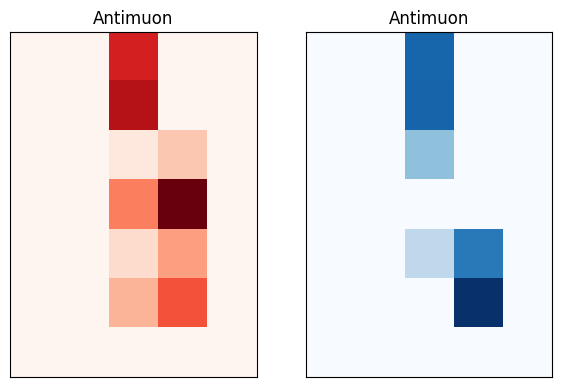

In [36]:
random_events = np.random.randint(0, aX_test.shape[0], 1)
print(random_events)
for i in random_events:
        plt.figure(figsize=(7,7))
        plt.subplot(1,2,1)
        
        # Event
        plt.imshow(aX_test[i,:,:,0], cmap='Reds')
        plt.title('Muon' if ay_test[i][0] == 0 else 'Antimuon')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2, sharex=plt.gca(), sharey=plt.gca())
        plt.imshow(aX_test[i,:,:,1], cmap='Blues')
        plt.title('Muon' if ay_test[i][0] == 0 else 'Antimuon')
        
        # Show tick labels on both sides
        plt.tick_params('x', labelbottom=True, labeltop=True)
        plt.tick_params('y', labelleft=True, labelright=True)
        
plt.show()

### Reconstructed antimuon event

[804]


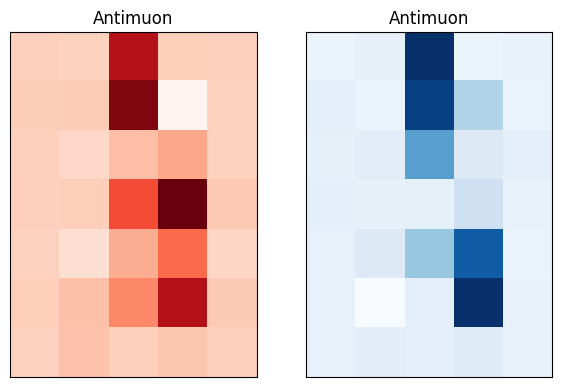

In [37]:
print(random_events)
for i in random_events:
        plt.figure(figsize=(7,7))
        plt.subplot(1,2,1)
        
        # Recostructed event
        plt.imshow(aX_test_pred[i,:,:,0], cmap='Reds')
        plt.title('Muon' if ay_test[i][0] == 0 else 'Antimuon')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2, sharex=plt.gca(), sharey=plt.gca())
        plt.imshow(aX_test_pred[i,:,:,1], cmap='Blues')
        plt.title('Muon' if ay_test[i][0] == 0 else 'Antimuon')
        
        # Show tick labels on both sides
        plt.tick_params('x', labelbottom=True, labeltop=True)
        plt.tick_params('y', labelleft=True, labelright=True)
        
plt.show()

### Neutron event

[9]


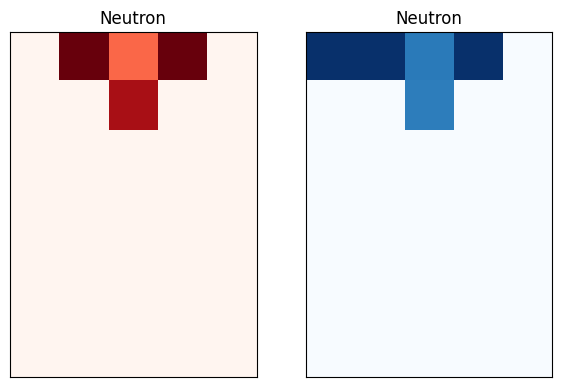

In [48]:
random_events = np.random.randint(0, nX.shape[0], 1)
print(random_events)

for i in random_events:
        plt.figure(figsize=(7,7))
        plt.subplot(1,2,1)
        
        # Event
        plt.imshow(nX[i,:,:,0], cmap='Reds')
        plt.title('Neutron')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2, sharex=plt.gca(), sharey=plt.gca())
        plt.imshow(nX[i,:,:,1], cmap='Blues')
        plt.title('Neutron')
        
        # Show tick labels on both sides
        plt.tick_params('x', labelbottom=True, labeltop=True)
        plt.tick_params('y', labelleft=True, labelright=True)

[9]


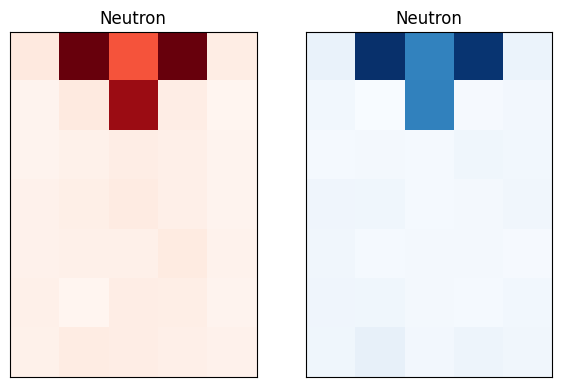

In [49]:
print(random_events)

for i in random_events:
        plt.figure(figsize=(7,7))
        plt.subplot(1,2,1)
        
        # Recostructed event
        plt.imshow(nX_pred[i,:,:,0], cmap='Reds')
        plt.title('Neutron')
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2, sharex=plt.gca(), sharey=plt.gca())
        plt.imshow(nX_pred[i,:,:,1], cmap='Blues')
        plt.title('Neutron')
        
        # Show tick labels on both sides
        plt.tick_params('x', labelbottom=True, labeltop=True)
        plt.tick_params('y', labelleft=True, labelright=True)